<a href="https://colab.research.google.com/github/rsidorchuk93/object_face_detection/blob/main/objects_and_face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object and face detection

In [2]:
# connecting to Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing required libraries**

In [3]:
pip install face_recognition deepface transformers torch timm pyheif Pillow -q

In [6]:
# Import libraries and initiating processor and model
from transformers import DetrImageProcessor, DetrForObjectDetection
from transformers import YolosFeatureExtractor, YolosForObjectDetection

import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import requests

# libraries for face recognition
import cv2
import numpy as np
from deepface import DeepFace
import dlib
import pyheif

## Object detection with pre-trained visual transformers

In [7]:
# Load and process images
photo_dir = '/content/drive/My Drive/test/photo_object_face_detection'
output_dir = os.path.join(photo_dir, 'persons')
os.makedirs(output_dir, exist_ok=True)

images = {}
for filename in os.listdir(photo_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        filepath = os.path.join(photo_dir, filename)
        image = Image.open(filepath)
        images[filename] = image

### DETR transformer

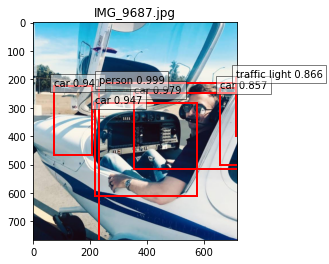

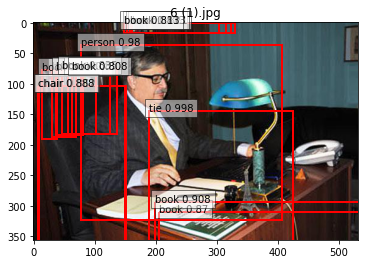

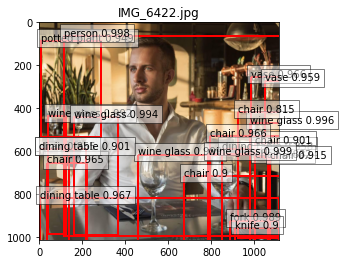

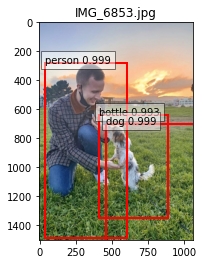

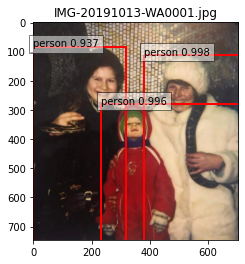

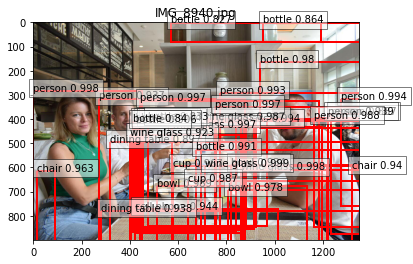

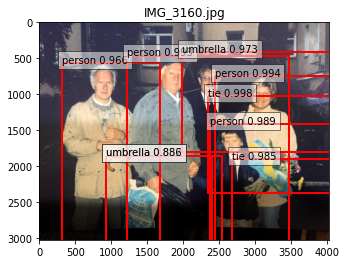

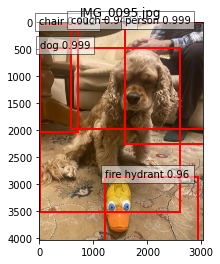

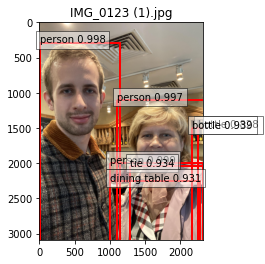

In [21]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

images = {}
for filename in os.listdir(photo_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        filepath = os.path.join(photo_dir, filename)
        image = Image.open(filepath)
        images[filename] = image

# Process and display each image
for image_name, image in images.items():
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.8)[0]

    # Find the largest detected person
    largest_person = None
    largest_area = 0

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if model.config.id2label[label.item()] == "person":
            x, y, width, height = [round(i, 2) for i in box.tolist()]
            area = width * height

            if area > largest_area:
                largest_area = area
                largest_person = box

    # Save the cropped image of the largest person to the "persons" subfolder
    if largest_person is not None:
        x, y, width, height = [round(i, 2) for i in largest_person.tolist()]
        cropped_image = image.crop((x, y, x + width, y + height))
        cropped_image.save(os.path.join(output_dir, f"person_{image_name}"))

    # Display the original image with bounding boxes, confidence scores, and object names
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.set_title(image_name)

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        label_str = model.config.id2label[label.item()]
        confidence = round(score.item(), 3)
        x, y, width, height = [round(i, 2) for i in box.tolist()]

        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        ax.text(x, y, f"{label_str} {confidence}", bbox=dict(facecolor="white", alpha=0.5))

    plt.show()

### Yolo (you look at only once) by Ultralytics

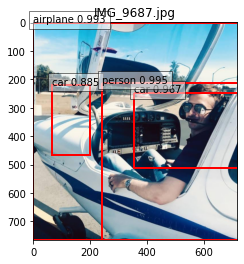

In [ ]:
# Complete Yolo model https://github.com/ultralytics/yolov5

# Object detection with yolos small
processor_yolos = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')
model_yolos = YolosForObjectDetection.from_pretrained('hustvl/yolos-small')

# Load and process images
# photo_dir = '/content/drive/My Drive/test/photo_object_face_detection'
# output_dir = os.path.join(photo_dir, 'persons')
os.makedirs(output_dir, exist_ok=True)

images = {}
for filename in os.listdir(photo_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        filepath = os.path.join(photo_dir, filename)
        image = Image.open(filepath)
        images[filename] = image

# Process and display each image
for image_name, image in images.items():
    inputs = processor_yolos(images=image, return_tensors="pt")
    outputs = model_yolos(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = processor_yolos.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.8)[0]

    # Find the largest detected person
    largest_person = None
    largest_area = 0

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if model_yolos.config.id2label[label.item()] == "person":
            x, y, width, height = [round(i, 2) for i in box.tolist()]
            area = width * height

            if area > largest_area:
                largest_area = area
                largest_person = box

    # Save the cropped image of the largest person to the "persons" subfolder
    if largest_person is not None:
        x, y, width, height = [round(i, 2) for i in largest_person.tolist()]
        cropped_image = image.crop((x, y, x + width, y + height))
        cropped_image.save(os.path.join(output_dir, f"person_{image_name}"))

    # Display the original image with bounding boxes, confidence scores, and object names
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.set_title(image_name)

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        label_str = model_yolos.config.id2label[label.item()]
        confidence = round(score.item(), 3)
        x, y, width, height = [round(i, 2) for i in box.tolist()]

        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        ax.text(x, y, f"{label_str} {confidence}", bbox=dict(facecolor="white", alpha=0.5))

    plt.show()

Out of the box transformer object detection model correctly detects people and some additional objects - animals, books, etc. As a next step, we'll crop persons and use face detection library to detect person's faces

## Face detection with face_detection library 
## This library requires GPU acceleration / Nvidia CUDA  

In [ ]:
# Requires GPU acceleration
import face_recognition

In [ ]:
# define necessary functions
def detect_faces(image):
    image_np = np.array(image)
    image_np_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

    face_locations = face_recognition.face_locations(image_np_rgb)
    face_images = []

    for (top, right, bottom, left) in face_locations:
        face_image = image_np[top:bottom, left:right]
        face_images.append(face_image)

    return face_locations, face_images

def draw_boundaries(image_np, face_locations, boundary_thickness=4):
    for (top, right, bottom, left) in face_locations:
        cv2.rectangle(image_np, (left, top), (right, bottom), (0, 0, 255), boundary_thickness)
    return Image.fromarray(image_np)

def save_largest_face(faces, name_prefix, save_dir):
    if not faces:
        return

    largest_face = max(faces, key=lambda face: face.shape[0] * face.shape[1])
    filepath = os.path.join(save_dir, f"{name_prefix}_largest_face.png")
    cv2.imwrite(filepath, cv2.cvtColor(largest_face, cv2.COLOR_RGB2BGR))

def face_percentage(face, image):
    face_size = face.shape[0] * face.shape[1]
    image_size = image.shape[0] * image.shape[1]
    return (face_size / image_size) * 100

Image: person_IMG_9687.jpg
Face 1 size: 3.77% of the image


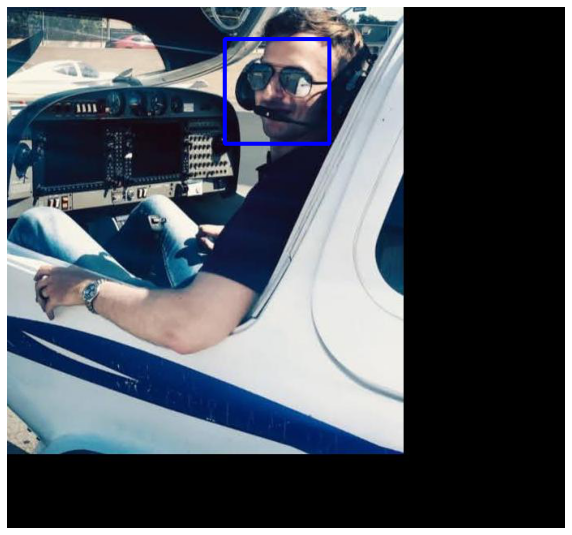

Image: person_IMG_6853.jpg


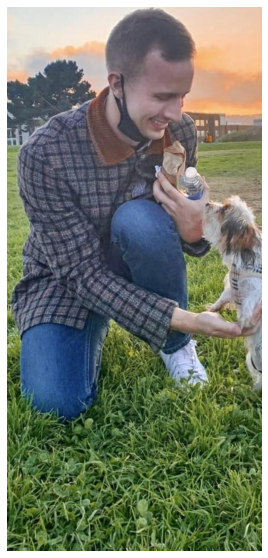

Image: person_IMG_6422.jpg
Face 1 size: 2.43% of the image


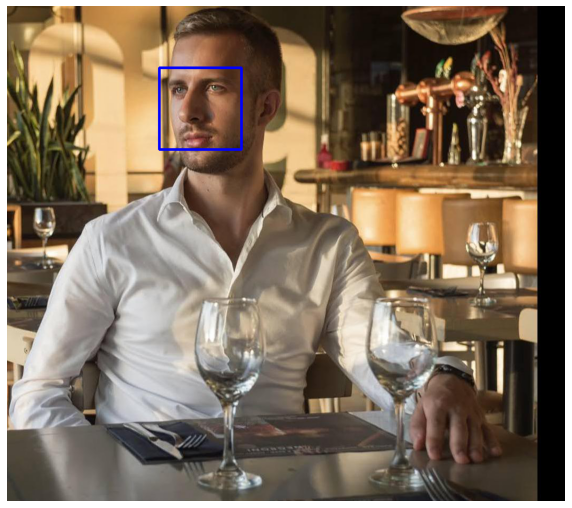

Image: person_6 (1).jpg
Face 1 size: 4.16% of the image


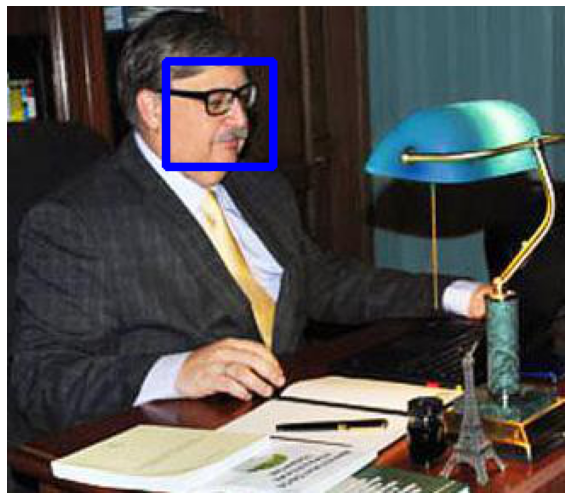

Image: person_IMG-20191013-WA0001.jpg


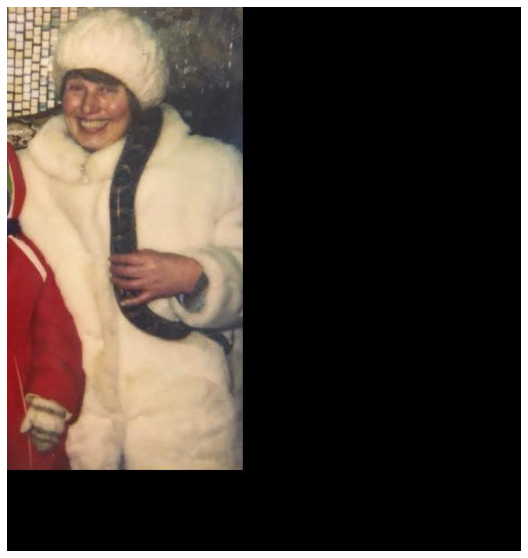

Image: person_IMG_3160.jpg
Face 1 size: 0.48% of the image
Face 2 size: 0.48% of the image


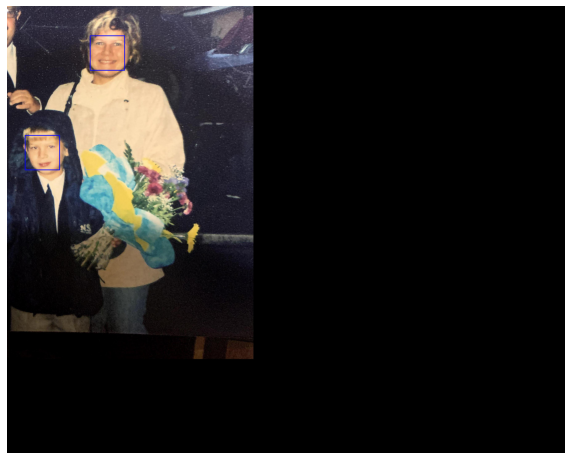

Image: person_IMG_8940.jpg
Face 1 size: 0.66% of the image
Face 2 size: 1.38% of the image


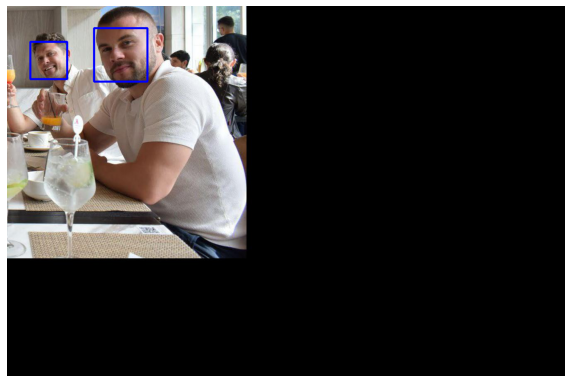

Image: person_IMG_0095.jpg


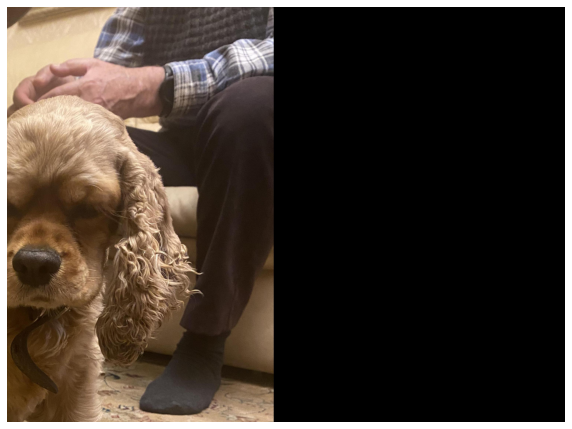

Image: person_IMG_0123 (1).jpg
Face 1 size: 0.11% of the image
Face 2 size: 6.27% of the image


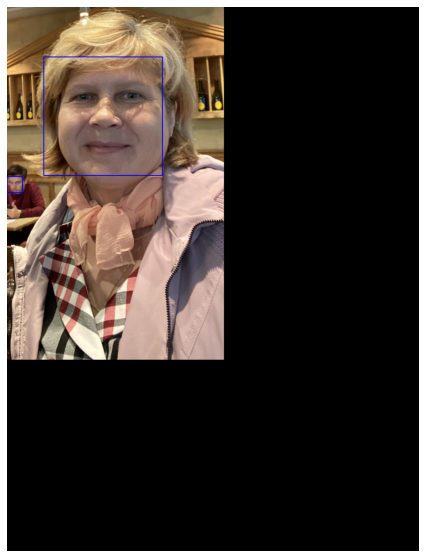

In [ ]:
# Load and process images
person_dir = output_dir
images = {}
for filename in os.listdir(person_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        filepath = os.path.join(person_dir, filename)
        image = Image.open(filepath)
        images[filename] = image

# Create the "faces" subfolder if it doesn't exist
faces_dir = os.path.join(photo_dir, "faces")
if not os.path.exists(faces_dir):
    os.makedirs(faces_dir)

# Process and display images
for name, image in images.items():
    # Detect faces and obtain face images
    face_locations, face_images = detect_faces(image)

    # Save the largest face in the "faces" subfolder
    save_largest_face(face_images, name.split('.')[0], faces_dir)

    # Draw red and thick boundaries and display the image
    image_np = np.array(image)
    processed_image = draw_boundaries(image_np, face_locations, boundary_thickness=4)

    # Print the results
    print(f'Image: {name}')
    for idx, face_image in enumerate(face_images):
        face_percent = face_percentage(face_image, image_np)
        print(f'Face {idx + 1} size: {face_percent:.2f}% of the image')
    plt.figure(figsize=(10, 10))  # Set a custom figure size for larger images
    plt.imshow(processed_image)
    plt.axis('off')
    plt.show()

## Race, emotion, gender, and age recognition with Deep Face library

Error: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
-------------------------------------------------------------------------------- 

Error: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
-------------------------------------------------------------------------------- 

Error: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
-------------------------------------------------------------------------------- 

Error: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
-------------------------------------------------------------------------------- 

Error: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection para

Action: race: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


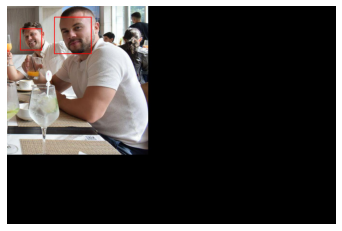

Face 1:
  Age:  26
  Dominant Gender:  Man
  Gender scores:  {'Woman': 0.02, 'Man': 99.98}
  Dominant Emotion:  neutral
  Emotions confidence:  {'angry': 0.13, 'disgust': 0.0, 'fear': 0.13, 'happy': 0.33, 'sad': 0.49, 'surprise': 0.21, 'neutral': 98.7}
  Dominant Race:  white
  Race scores:  {'asian': 0.0, 'indian': 0.01, 'black': 0.0, 'white': 94.88, 'middle eastern': 2.63, 'latino hispanic': 2.49}

-------------------------------------------------------------------------------- 



Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


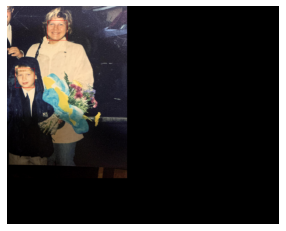

Face 1:
  Age:  27
  Dominant Gender:  Man
  Gender scores:  {'Woman': 2.42, 'Man': 97.58}
  Dominant Emotion:  fear
  Emotions confidence:  {'angry': 8.09, 'disgust': 0.0, 'fear': 69.75, 'happy': 0.57, 'sad': 5.19, 'surprise': 0.56, 'neutral': 15.83}
  Dominant Race:  white
  Race scores:  {'asian': 7.44, 'indian': 0.01, 'black': 0.0, 'white': 89.54, 'middle eastern': 0.79, 'latino hispanic': 2.21}

Face 2:
  Age:  37
  Dominant Gender:  Man
  Gender scores:  {'Woman': 9.09, 'Man': 90.91}
  Dominant Emotion:  happy
  Emotions confidence:  {'angry': 0.0, 'disgust': 0.0, 'fear': 0.02, 'happy': 99.95, 'sad': 0.01, 'surprise': 0.0, 'neutral': 0.02}
  Dominant Race:  white
  Race scores:  {'asian': 0.02, 'indian': 0.01, 'black': 0.0, 'white': 95.38, 'middle eastern': 1.82, 'latino hispanic': 2.77}

-------------------------------------------------------------------------------- 

Error: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_d

Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


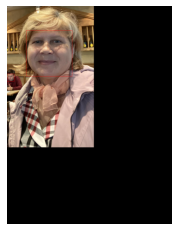

Face 1:
  Age:  42
  Dominant Gender:  Man
  Gender scores:  {'Woman': 47.54, 'Man': 52.46}
  Dominant Emotion:  happy
  Emotions confidence:  {'angry': 0.12, 'disgust': 0.0, 'fear': 0.07, 'happy': 92.24, 'sad': 0.08, 'surprise': 1.51, 'neutral': 5.97}
  Dominant Race:  white
  Race scores:  {'asian': 0.25, 'indian': 0.1, 'black': 0.01, 'white': 85.06, 'middle eastern': 4.98, 'latino hispanic': 9.6}

Face 2:
  Age:  26
  Dominant Gender:  Man
  Gender scores:  {'Woman': 2.24, 'Man': 97.76}
  Dominant Emotion:  sad
  Emotions confidence:  {'angry': 35.04, 'disgust': 0.0, 'fear': 1.38, 'happy': 7.02, 'sad': 51.93, 'surprise': 0.0, 'neutral': 4.63}
  Dominant Race:  middle eastern
  Race scores:  {'asian': 0.14, 'indian': 3.93, 'black': 0.2, 'white': 29.2, 'middle eastern': 57.82, 'latino hispanic': 8.7}

-------------------------------------------------------------------------------- 



In [8]:
# Directory containing the images
person_dir = output_dir

# List all files in the directory
file_list = os.listdir(person_dir)

# Iterate over the files in the directory
for file in file_list:
    # Create the full image path
    image_path = os.path.join(person_dir, file)

    # Check if the file is an image (you can add more extensions if needed)
    if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    try:
        # Analyze the image for age, gender, emotion, and race
        results = DeepFace.analyze(image_path, actions=["age", "gender", "emotion", "race"])

        # If there's only one face detected, the result is a dictionary. Otherwise, it's a list of dictionaries.
        if isinstance(results, dict):
            results = [results]

    except ValueError as e:
        print(f"Error: {e}")
        print('-' * 80, '\n')
        continue

    # Load the dlib face detector
    face_detector = dlib.get_frontal_face_detector()

    # Open the image and convert it to RGB
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Detect faces and get the bounding box coordinates
    detected_faces = face_detector(image)

    # Draw red bounding boxes around detected faces
    for face in detected_faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Display the image with bounding boxes
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    # Iterate through the results and print the predictions
    for i, result in enumerate(results):
        print(f"Face {i + 1}:")
        print("  Age: ", result["age"])

        print("  Dominant Gender: ", result["dominant_gender"])
        rounded_gender = {k: round(v, 2) for k, v in result["gender"].items()}
        print("  Gender scores: ", rounded_gender)

        # Round emotion values to the second decimal place
        print("  Dominant Emotion: ", result["dominant_emotion"])
        rounded_emotions = {k: round(v, 2) for k, v in result["emotion"].items()}
        print("  Emotions confidence: ", rounded_emotions)

        # Round race values to the second decimal place
        print("  Dominant Race: ", result["dominant_race"])
        rounded_race = {k: round(v, 2) for k, v in result["race"].items()}
        print("  Race scores: ", rounded_race)

        print()

    print('-' * 80, '\n')
